### <span style="color:rgb(234,81,96)">Optimization for Machine Learning</span>
### <span style="color:rgb(234,81,96)">Master 2 IASD Apprentissage, 2023-2024</span>

# <span style="color:rgb(234,81,96)">Lab 05 - Stochastic gradient methods in practice</span>


Lecture notes for this course are available [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OAA/PolyOAA.pdf).

This Jupyter notebook can be obtained [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OAA/SourcesLabOAA05.zip).

For any comment regarding this notebook (including typos), please send an email to: **clement.royer@lamsade.dauphine.fr**.

For a better performance, this notebook should be run via [Google Colabs](https://colab.research.google.com/notebooks/welcome.ipynb) (requires a Google account). Otherwise, the packages associated with PyTorch may need to be installed in your local Python distribution.

# <span style="color:rgb(234,81,96)">Foreword</span>

The goal of this lab session is to evolve from the setup of the first lab session, where we built a stochastic gradient method *from scratch*, to the modern practice of invoking standard optimization packages for ML tasks such as PyTorch. This allows for more reliable and efficient implementations.

Part 1 of this notebook is concerned with Autograd, a popular automatic differentiation package.

Part 2 focuses on implementing regression and classification tasks within the PyTorch framework. As we will see, most of the routines we hand-coded in other lab sessions are already built in within PyTorch.

Part 3 is optional, and presents more sophisticated tools and (neural network) structures for optimization in ML.

In [1]:
# Importing useful packages from PyTorch
import torch
from torch import nn # Neural networls
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.backends import cudnn # CUDA neural networks
cudnn.benchmarks = True
import time

# Other imports
import numpy as np # Numpy
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz

# <span style="color:rgb(234,81,96)"> Part 1: Automatic differentiation via Autograd</span>

Most optimization algorithms that we studied in this course relied on the gradient, i.e. the derivative of the function. For complex models, this derivative can be expensive to compute. The Autograd package uses *automatic differentiation* to compute gradients numerically and efficiently from the code of the function.




## <span style="color:rgb(234,81,96)">1.1 Tensors and PyTorch</span>

Tensors are multidimensional arrays, that generalize the concepts of scalars (0 dimension), vectors (1 dimension) and matrices (2 dimensions). PyTorch tensors are similar to NumPy arrays, and are at the heart of automatic differentiation in PyTorch. 

In this section, we study the basics of PyTorch tensors.

In [5]:
# Several examples of PyTorch tensors

#  A vector of size 2
x1 = torch.tensor([10.0,20.0])
print(x1) # Tensor objects can be printed (yet difficult to visualize in many dimensions!)

#  A matrix of size 2x1
x2 = torch.tensor([[10],[20]])
print(x2)

#  A matrix of dimensions 1x2,
x3 = torch.tensor([[10,20]])
print(x3)

# A "0 dimension" tensor, i.e. a scalar
x4 = torch.tensor(3.0)
print(x4)

# A zero-filled matrix of size 3x4
x5 = torch.zeros(3,4)
print(x5)

# A 2x2 matrix with normal random coefficients
x6 = torch.randn(2,2)
print(x6)

tensor([10., 20.])
tensor([[10],
        [20]])
tensor([[10, 20]])
tensor(3.)
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[ 0.1619, -0.6078],
        [ 0.7681,  1.4239]])


Operations on PyTorch tensors work the same way as for NumPy arrays.

In [7]:
# Add 3 to all elements
x5 = x1 + 3
print(x5)
# Square every elements in x5
x6 = x5 ** 2
print(x6)
# Fill a vector with zeros
x6.zero_()
print(x6)

tensor([13., 23.])
tensor([169., 529.])
tensor([0., 0.])


In [8]:
# Transpose a matrix
x7 = x2.t()
print(x7)

# Reshaping a vector
x8 = x7.view(2,1)
print(x8)

# Matrix multiplication (2 equivalent formulations)
x9 = torch.mm(x8,x7)
x10 = x8 @ x7
print(x9)
print(x10)

# Component-wise product
x11 = x7*x7
print(x11)

tensor([[10, 20]])
tensor([[10],
        [20]])
tensor([[100, 200],
        [200, 400]])
tensor([[100, 200],
        [200, 400]])
tensor([[100, 400]])


It is possible to convert NumPy arrays to PyTorch tensors and vice-versa.

In [9]:
# Convert a Pytorch to a NumPy array
x7_numpy = x7.numpy()

# Convert a NumPy array to a PyRorch array
a=np.arange(10) # Generates a NumPy array with a range of 10 values (by default, starts at 0 and values are spaced by 1)
print(a)
a_torch = torch.tensor(a,dtype=torch.float)
print(a_torch)

[0 1 2 3 4 5 6 7 8 9]
tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])


## <span style="color:rgb(234,81,96)">1.2 Cuda Tensors</span>

Cuda tensors are a specific kind of tensors that can be efficiently implemented and manipulated on GPUs.

***NB: This section can and should be skipped if the notebook is not run on Colabs or a platform with at least one GPU.***

In [10]:
# Run this command to see if cuda is installed
print(torch.cuda.is_available())
# If so, we can use a GPU device; otherwise, standard tensors will be used.
if torch.cuda.is_available():
    # Index of currently selected device
    print(torch.cuda.current_device())
    # Obtain the name of the current device (0 here)
    torch.cuda.get_device_name(0) 
    # Number of GPUs available
    print(torch.cuda.device_count())

True
0
1


In [11]:
if torch.cuda.is_available():
    a = torch.Tensor([1,2])
    # Get the device on which the tensor is stored
    print(a.get_device())
    # a.cuda() returns a copy of the object in Cuda memory
    a = a.cuda()
    print(a.get_device())

-1
0


In [12]:
if torch.cuda.is_available():
    # This retuns an error: one cannot convert a Cuda Tensor to a Numpy array directly
    a.numpy()

TypeError: ignored

In [13]:
if torch.cuda.is_available():
    # To convert a Cuda tensor into a Numpy array, copy the tensor in CPU memory first
    a.cpu().numpy()

## <span style="color:rgb(234,81,96)">1.3 Autograd</span>

We now describe the ideas behind automatic differentiation as well as their implementation in PyTorch.

When creating a PyTorch tensor ``x``, one can ''track'' the gradient with respect to ``x`` of any subsequent function of ``x`` by specifying ``requires_grad=True`` in its definition.

In [14]:
x=torch.ones(10,10,requires_grad=True)
y=3*x
print(y.grad_fn)

In the above example, the gradient with respect to x is tracked within the graph of dependencies of y with respect to x. The operations are recorded in the structure ``y.grad_fn``, and will be used to compute the gradient of ``y`` with respect to ``x``.

By default, ``requires_grad`` is set to ``True``. If *requires_grad*=*False*, no dependency will be tracked, as shown by the example below.

In [15]:
# PyTorch tensors without tracking dependencies
x=torch.ones(10,10,requires_grad = False)
y=3*x
y =y.sum()


print(y.grad_fn)

None


Note that it is not possible to start tracking gradients once operations have been made on the graph.

In [16]:
x=torch.ones(10,10,requires_grad = False)
y=3*x
y =y.sum()
print(y.grad_fn)
x.requires_grad_(True)
print(y.grad_fn)

None
None


We know turn to the actual gradient calculation process, which corresponds to a **backward pass** in the computational graph.

In [17]:
x=torch.ones(10,10,requires_grad = True)
y=3*x
y = y.sum()
y.backward()

Once this backward pass has been performed, the derivative of y with respect to x is available directly from x through the operation ``x.grad``

In [18]:
# x.grad plots the tensor of derivatives of y with respect to every component of the tensor x.
x.grad

tensor([[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]])

In the previous example, y is a scalar (equal to 3 times the sum of elements of x). When y is a tensor, one then needs to specify a tensor w.r.t. which the derivation will be performed.

In [19]:
# INCORRECT WAY TO COMPUTE THE GRADIENT FOR A TENSOR-VALUED FUNCTION
# This block returns an error as y is not a scalar
x=torch.ones(10,10,requires_grad = True)
y=3*x

y.backward()

RuntimeError: ignored

In [20]:
# Correct way to obtain gradients for a tensor-valued function 
# (Note: In this case, the gradient is sometimes called the Jacobian or the tensor derivative)
x=torch.ones(10,10,requires_grad = True)
y=3*x

y.backward(torch.ones(x.shape)) # Putting values other than ones here would scale the gradient
print(x.grad)

tensor([[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]])


To obtain two or more gradients, we use the same process.

In [21]:
# An example with a function of two (scalar) tensors.
# The call to backward() will compute the gradient w.r.t. both a and b
a = torch.ones(1, requires_grad = True)
b = torch.ones(1, requires_grad = True)
y=(a+4*b)**2
y.backward()
print(a.grad)
print(b.grad)


tensor([10.])
tensor([40.])


Remark: A *tracked tensor*, i.e. a tensor for which *requires_grad*=*True*, cannot be directly converted to a NumPy array. One first needs to detach the tracking of the variable.

In [22]:
# This code generates an error
a.numpy()

RuntimeError: ignored

In [23]:
# This code is valid
x= a.detach()
print(x)
x_numpy = x.numpy()
print(x_numpy)


tensor([1.])
[1.]


#### <span style="color:rgb(234,81,96)">Example</span>

Using PyTorch tensors and Autograd, we plot the function $f(x)=(1+x^2e^{-x})^{1/3}$ and its derivative on [-1,1].

---



tensor([-1.1326e+00, -1.1127e+00, -1.0926e+00, -1.0722e+00, -1.0515e+00,
        -1.0305e+00, -1.0092e+00, -9.8760e-01, -9.6566e-01, -9.4340e-01,
        -9.2080e-01, -8.9787e-01, -8.7459e-01, -8.5098e-01, -8.2703e-01,
        -8.0276e-01, -7.7817e-01, -7.5328e-01, -7.2809e-01, -7.0264e-01,
        -6.7693e-01, -6.5101e-01, -6.2490e-01, -5.9863e-01, -5.7224e-01,
        -5.4577e-01, -5.1927e-01, -4.9278e-01, -4.6635e-01, -4.4004e-01,
        -4.1390e-01, -3.8798e-01, -3.6233e-01, -3.3702e-01, -3.1210e-01,
        -2.8762e-01, -2.6363e-01, -2.4018e-01, -2.1732e-01, -1.9509e-01,
        -1.7353e-01, -1.5267e-01, -1.3255e-01, -1.1318e-01, -9.4591e-02,
        -7.6797e-02, -5.9810e-02, -4.3637e-02, -2.8279e-02, -1.3735e-02,
         5.9212e-16,  1.2935e-02,  2.5083e-02,  3.6458e-02,  4.7078e-02,
         5.6963e-02,  6.6135e-02,  7.4615e-02,  8.2429e-02,  8.9602e-02,
         9.6160e-02,  1.0213e-01,  1.0753e-01,  1.1240e-01,  1.1676e-01,
         1.2063e-01,  1.2405e-01,  1.2703e-01,  1.2

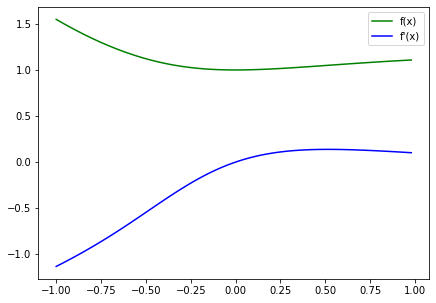

In [24]:
# Creating a NumPy array with values in [-1,1]
v=np.arange(-1,1,0.02) # Other possibility: use np.linspace(-1,1,100)

# Creating the corresponding PyTorch tensor
x=torch.tensor(v,requires_grad = True)
# Forming the tensor containing the values f(x_i) for every coefficient x_i of x 
# NB: We could differentiate any of these variables with respect to x.
y=x**2
z=torch.exp(-x)
w=1+y*z
f = w**(1/3)

# Calling backward on f (Important: f is a tensor, not a scalar)
f.backward(torch.ones(x.shape))
print(x.grad)

# Plotting the values in f and x.grad
# In order to plot them like NumPy arrays, we need to use the detach() function (see Section 1.1).
plt.figure(figsize=(7, 5))
plt.plot(v,f.detach().numpy(),'g',label='f(x)')
plt.plot(v,x.grad.detach().numpy(),'b',label="f'(x)")
plt.legend()
plt.show()

## <span style="color:rgb(234,81,96)"> 1.4 Application: Linear regression using Autograd</span>

We now consider the same data generator as in the first lab session.

In [25]:
# Data generation.
# This code is inspired by a generator proposed by A. Gramfort.
    
def simu_linreg(w, n, std=1., corr=0.5):
    """
    Simulation of the least-squares problem
    
    Parameters
    ----------
    w : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the feature matrix
    """    
    d = w.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = X.dot(w) + noise
    return X, y

In [26]:
d = 50
n = 1000
idx = np.arange(d)

# Ground truth coefficients of the model
w_model_truth = (-1)**idx * np.exp(-idx / 10.)

# Data X and y are generated accordingly
X, y = simu_linreg(w_model_truth, n, std=1., corr=0.1)
X=torch.as_tensor(X,dtype = torch.float)
y=torch.as_tensor(y,dtype = torch.float).view(-1,1)

The gradient descent code below uses Autograd to compute the gradient, with a stepsize of $0.1$.

Iteration 0/100 : Loss :5.8679656982421875
Iteration 10/100 : Loss :1.131339192390442
Iteration 20/100 : Loss :0.9910747408866882
Iteration 30/100 : Loss :0.9849121570587158
Iteration 40/100 : Loss :0.9845978021621704
Iteration 50/100 : Loss :0.9845802187919617
Iteration 60/100 : Loss :0.9845790863037109
Iteration 70/100 : Loss :0.9845791459083557
Iteration 80/100 : Loss :0.9845790863037109
Iteration 90/100 : Loss :0.9845790863037109


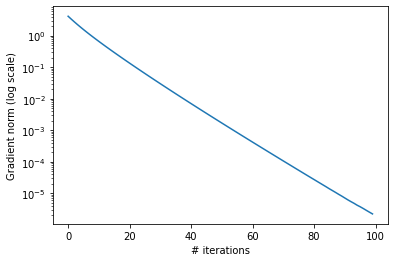

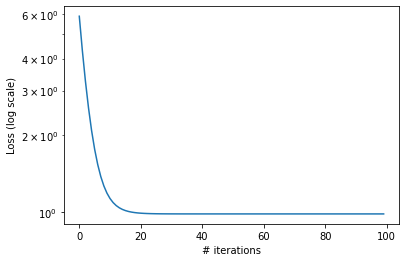

In [32]:
# Start from zero
w = torch.zeros((d,1),requires_grad = True)
nb_iters = 100

grad_norms = []
losses = []
# Main gradient descent loop
for i in range(nb_iters):
    
    # Evaluate the loss function ||X*w-y||^2
    y_pred = torch.mm(X,w)
    loss = (y-y_pred)**2
    loss = loss.mean()
    # Compute the gradient via backward
    loss.backward()

    # Compute a gradient descent step - Here we choose the stepsize to be constant equal to 0.1
    # Two differences with gradient descent as we implemented it in Lab01:
    # a) We cannot write the classical iteration (w=w-0.1*w.grad or w-=0.1*w.grad) because it will update 
    # w and consider it as a function of w! This cannot be done in PyTorch and yields the following error:
    #       RuntimeError: a leaf Variable that requires grad has been used in an in-place operation
    # We need to use the no_grad() function from the torch package to 
    # indicate that we do not want this update to matter in the gradient calculation.
    #
    # b) Every gradient value that is calculated is added to the value in w.grad : After the function has been updated,
    # we thus need to reset the gradient of w so that the gradients do not add up.

    with torch.no_grad():
        w -= 0.1*w.grad
    grad_norms.append(torch.norm(w.grad).detach())
    losses.append(loss)
    w.grad.zero_()   
    
    
    if i% 10 == 0:
        print("Iteration {}/{} : Loss :{}".format(i,nb_iters,loss))

        
        
# Plot the gradient norm and the loss (objective) function        
plt.figure()
plt.semilogy(grad_norms)
plt.ylabel("Gradient norm (log scale)")
plt.xlabel("# iterations")
plt.show()


plt.figure()
plt.semilogy(losses)
plt.ylabel("Loss (log scale)")
plt.xlabel("# iterations")
plt.show()

# <span style="color:rgb(234,81,96)"> Part 2 - PyTorch *nn* and *optim* packages </span>

In the last example, we only used PyTorch to compute the gradient. It is actually possible to implement both the linear regression problem and the gradient descent algorithm using instances of the PyTorch classes nn.Module and torch.optim, respectively.

## <span style="color:rgb(234,81,96)"> 2.1 An illustration: Gradient descent for linear regression</span>

In [33]:
# Define a class for linear models (predictors)
class LinearPredictor(nn.Module):
    def __init__(self,d,k):
        super(LinearPredictor,self).__init__()
        self.linear = nn.Linear(d,k,bias=False)
    
    # Forward operator: Computes the prediction of a linear model (x^T*w)
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        y = self.linear(x)
        return y
    

In [30]:
# Form the optimization problem: Optimize the parameters of a linear regression 
# model with mean-squared error (i.e. quadratic) loss as the objective, using a ``stochastic gradient descent''
# algorithm (can correspond to gradient descent or stochastic gradient)
linreg = LinearPredictor(d,1)
criterion = nn.MSELoss(reduction = 'mean')
optimizer = torch.optim.SGD(linreg.parameters(),lr=0.1)

Below is an example of a gradient descent implementation for this problem.

Iteration 0/100 : Loss : 5.8679656982421875
Iteration 10/100 : Loss : 1.131339192390442
Iteration 20/100 : Loss : 0.9910747408866882
Iteration 30/100 : Loss : 0.9849121570587158
Iteration 40/100 : Loss : 0.9845978021621704
Iteration 50/100 : Loss : 0.9845803380012512
Iteration 60/100 : Loss : 0.9845790863037109
Iteration 70/100 : Loss : 0.9845791459083557
Iteration 80/100 : Loss : 0.9845790266990662
Iteration 90/100 : Loss : 0.9845790863037109


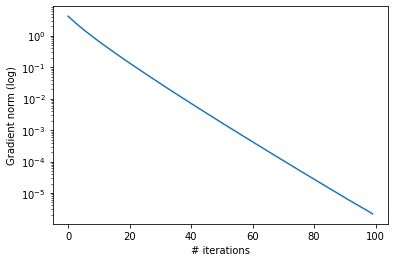

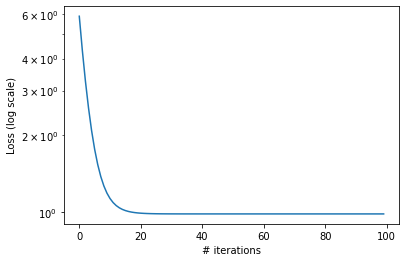

In [31]:
# Gradient descent for linear regression using torch packages
for p in linreg.parameters():
    p.data = torch.zeros(p.data.shape)
    
nb_iters = 100

grad_norms = []
losses = []
for i in range(nb_iters):

    #  Compute the loss function
    y_pred = linreg(X) # NB: X are defined as in Section 1.4 above
    loss = criterion(y_pred,y)
    loss = loss.mean()
    # Calculate the gradient 
    loss.backward()
    # Do one step of gradient descent with the full gradient
    optimizer.step()
    
    grad_norms.append(torch.norm(list(linreg.parameters())[0].grad.data).detach())
    losses.append(loss.item())
    
    optimizer.zero_grad()
    

    if i% 10 == 0:
        print("Iteration {}/{} : Loss : {}".format(i,nb_iters,loss))

# Plot gradient norm and loss function
plt.figure()
plt.semilogy(grad_norms)
plt.ylabel("Gradient norm (log)")
plt.xlabel("# iterations")
plt.show()


plt.figure()
plt.semilogy(losses)
plt.ylabel("Loss (log scale)")
plt.xlabel("# iterations")
plt.show()

##  <span style="color:rgb(234,81,96)">2.2 Stochastic gradient for linear regression in PyTorch</span>

In [34]:
# Select problem instance and optimizer
linreg = LinearPredictor(d,1)
criterion = nn.MSELoss(reduction = 'mean')
optimizer = torch.optim.SGD(linreg.parameters(),lr=0.1)


The code below runs SGD as a batch stochastic gradient (of batch size $b$, see below).

In [ ]:
# Code for stochastic gradient using the optim.SGD class with a batch stochastic gradient
for p in linreg.parameters():
    p.data = torch.zeros(p.data.shape)
    
nb_iters = n*100
b = 1 # batch size

grad_norms = []
losses = []
for i in range(nb_iters):
    
    optimizer.zero_grad()
    choice_batch = np.random.choice(np.arange(n),size = b)
    X_b = X[choice_batch]
    y_b = y[choice_batch]
    y_pred = linreg(X_b)
    loss = criterion(y_pred,y_b)
    loss.backward()
    optimizer.step()

    # Plot appropriate quantities after every epoch
    if  (i*b) % n == 0:
        optimizer.zero_grad()
        y_pred = linreg(X)
        loss = criterion(y_pred,y)
        loss = loss.mean()
        loss.backward()
        grad_norms.append(torch.norm(list(linreg.parameters())[0].grad.data).detach())
        losses.append(loss.item())
        print("Iteration {}/{} : Loss : {}".format(i,nb_iters,loss))



    # Update learning rate/stepsize: here we chose a decreasing stepsize
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.1/np.sqrt(i+1)
     

Iteration 0/100000 : Loss : 24.08277130126953
Iteration 1000/100000 : Loss : 1.0312297344207764
Iteration 2000/100000 : Loss : 0.9867491722106934
Iteration 3000/100000 : Loss : 0.9196421504020691
Iteration 4000/100000 : Loss : 0.9265223741531372
Iteration 5000/100000 : Loss : 0.930971086025238
Iteration 6000/100000 : Loss : 0.911715030670166
Iteration 7000/100000 : Loss : 0.9218866229057312
Iteration 8000/100000 : Loss : 0.8935813903808594
Iteration 9000/100000 : Loss : 0.9083192348480225
Iteration 10000/100000 : Loss : 0.9130901098251343
Iteration 11000/100000 : Loss : 0.8849766254425049
Iteration 12000/100000 : Loss : 0.8980252146720886
Iteration 13000/100000 : Loss : 0.8771864175796509
Iteration 14000/100000 : Loss : 0.8931546807289124
Iteration 15000/100000 : Loss : 0.8758766651153564
Iteration 16000/100000 : Loss : 0.880808413028717
Iteration 17000/100000 : Loss : 0.8928748369216919
Iteration 18000/100000 : Loss : 0.8847684264183044
Iteration 19000/100000 : Loss : 0.87930458784103

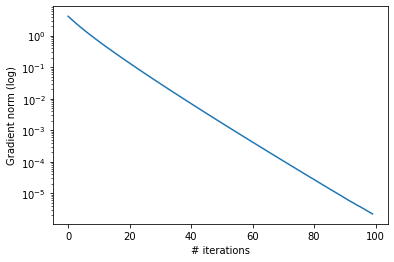

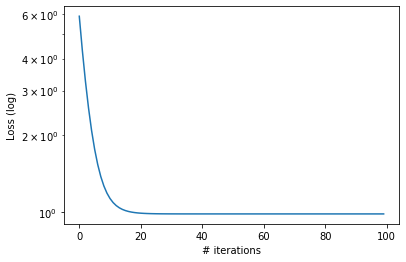

In [35]:
# Plot the results
plt.figure()
plt.semilogy(grad_norms)
plt.ylabel("Gradient norm (log)")
plt.xlabel("# iterations")
plt.show()


plt.figure()
plt.semilogy(losses)
plt.ylabel("Loss (log)")
plt.xlabel("# iterations")
plt.show()

## <span style="color:rgb(234,81,96)"> 2.3 Classification using PyTorch</span>

In [36]:
# We use data from MNIST, a dataset of handwritten digits
bs = 64

# Load MNIST data
train_data = torchvision.datasets.MNIST("datasets/", 
                                       train=True,
                                        transform=torchvision.transforms.Compose([
                                                   torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize(
                                                     (0.1307,), (0.3081,))
                                                 ]), 
                                        target_transform=None, download=True)



# Load MNIST data
test_data = torchvision.datasets.MNIST("datasets/", 
                                        train=False,
                                        transform=torchvision.transforms.Compose([
                                                   torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize(
                                                     (0.1307,), (0.3081,))
                                                 ]), 
                                        target_transform=None, download=True)




n_data_train = len(train_data.data)
n_data_test = len(test_data.data)

Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw



Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw


Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw


Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


We now train several optimizers from the torch.optim package on the MNIST dataset. 
*A look at the [PyTorch SGD documentation](https://pytorch.org/docs/stable/optim.html#torch.optim) can be helpful to understand the rest of the code.*

In [38]:
## Training with several optimizers on MNIST
def train(model,bs,n_epochs,optimizer,gpu_mode=True):
    if gpu_mode:
        model = model.cuda()

    train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=bs,
                                          shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=bs,
                                            shuffle=True)
    
    
    # We use the cross-entropy loss, particularly useful in classification problems
    criterion = nn.CrossEntropyLoss(reduction = 'mean')

    # We have the choice between three possible optimizers (and we'll compare them in section 2.6). 
    # Check the PyTorch documentation for more information on Adam and RMSprop.
    if optimizer == "SGD":
        optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
    elif optimizer == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    elif optimizer == "RMSprop":
        optimizer = torch.optim.RMSprop(model.parameters(),lr=0.001)

    losses_train = []
    losses_test = []
    acc_train = []
    acc_test=[]
    for n in range(n_epochs):
        beg_epoch = time.time()

        i = 0
        for x, y in train_loader:
            # Use CUDA tensors if GPU(s) available
            if gpu_mode:
                x,y = x.cuda(), y.cuda()

            y_pred = model(x)
            loss = criterion(y_pred,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            i += 1 


            with torch.no_grad():
                y_pred =  torch.argmax(y_pred,dim=1)
                acc = (y_pred == y).sum().item()

                acc_train.append(acc/len(y))
                losses_train.append(loss.item())
                if i % 50 == 0 :
                    print("Epoch [{}/{}], [{}/{}], batch loss = {}, epoch time = {}".format(n+1,n_epochs,i*bs,n_data_train,loss.item(),time.time()-beg_epoch))    
        with torch.no_grad():
            # ADD the code for evalution of the loss and accuracy on the test set here
            loss = 0
            acc = 0
            for x, y in test_loader:
                if gpu_mode:
                    x,y = x.cuda(), y.cuda()
                y_pred = model(x)

                
                curr_loss = criterion(y_pred,y)
                loss += len(y)*curr_loss.item()

                y_pred = torch.argmax(y_pred,dim=1)
                acc += (y_pred == y).sum().item()
            # END ADDED CODE
            acc_test.append(acc/n_data_test)
            losses_test.append(loss/n_data_test)

        print("Epoch [{}/{}], test accuracy = {}, testloss = {}, total epoch time = {}".format(n+1,n_epochs,acc/n_data_test,loss/n_data_test,time.time()-beg_epoch))

    return losses_train, losses_test, acc_train, acc_test

In [39]:
## Testing script for the code
# The code will be slower if run with gpu_mode=False (but won't run with gpu_mode=True if no GPU(s) are available)
model = LinearPredictor(784,10)
opt = "SGD"
#losses_train, losses_test,acc_train, acc_test = train(model,bs=500,n_epochs=10,optimizer=opt,gpu_mode=True)
losses_train, losses_test,acc_train, acc_test = train(model,bs=500,n_epochs=10,optimizer=opt,gpu_mode=False)



Epoch [1/10], [25000/60000], batch loss = 1.9212188720703125, epoch time = 4.388010025024414
Epoch [1/10], [50000/60000], batch loss = 1.5613982677459717, epoch time = 8.599504947662354
Epoch [1/10], test accuracy = 0.6331, testloss = 1.4607947051525116, total epoch time = 11.88004183769226
Epoch [2/10], [25000/60000], batch loss = 1.3027596473693848, epoch time = 4.215657711029053
Epoch [2/10], [50000/60000], batch loss = 1.1458674669265747, epoch time = 8.247860670089722
Epoch [2/10], test accuracy = 0.7633, testloss = 1.0801032960414887, total epoch time = 11.438286304473877
Epoch [3/10], [25000/60000], batch loss = 1.0172698497772217, epoch time = 4.215636253356934
Epoch [3/10], [50000/60000], batch loss = 0.9874776601791382, epoch time = 8.238672733306885
Epoch [3/10], test accuracy = 0.8125, testloss = 0.8899235755205155, total epoch time = 11.481548547744751
Epoch [4/10], [25000/60000], batch loss = 0.8769786357879639, epoch time = 4.26997709274292
Epoch [4/10], [50000/60000], b

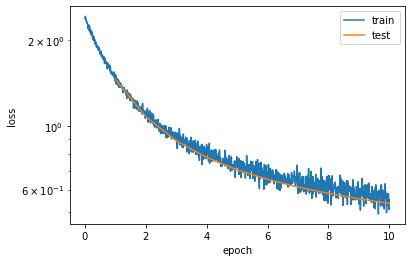

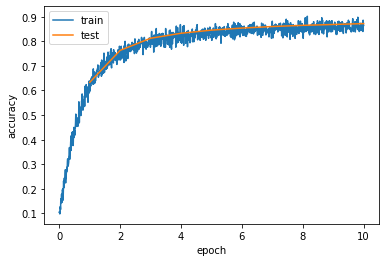

In [41]:
# Plotting the results

# Loss function
plt.figure()
plt.semilogy(np.linspace(0,10,len(losses_train)),losses_train,label="train")
plt.semilogy(np.linspace(1,10,len(losses_test)),losses_test,label="test")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

# Classification accuracy
plt.figure()
plt.plot(np.linspace(0,10,len(acc_train)),acc_train,label="train")
plt.plot(np.linspace(1,10,len(acc_test)),acc_test,label="test")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# <span style="color:rgb(234,81,96)">Part 3 - Additional experiments using other models</span>



## <span style="color:rgb(234,81,96)">3.1 Multilayer perceptron </span>


We now add layers of linear predictors in order to make a better prediction.

In [42]:
# Class MLP built on nn.Linear - inherits from nn.Module
class MLP(nn.Module):
    def __init__(self,d):
        super(MLP,self).__init__()
        self.linear_1 = nn.Linear(d,100,bias=True)
        self.linear_2 = nn.Linear(100,40,bias=True)
        self.linear_3 = nn.Linear(40,10,bias=True)


    
    def forward(self,x):
        y = x.view(x.shape[0],-1)
        y = F.relu(self.linear_1(y))
        y = F.relu(self.linear_2(y))
        y = self.linear_3(y)
        return y

In [43]:
# Running SGD. We only changed the model
model = MLP(784)
opt = "SGD"
opt_params = {'lr' : 0.01}
#losses_train, losses_test,acc_train, acc_test = train(model,bs=64,n_epochs=10,optimizer=opt)
# Use this command if not running with GPUs available
losses_train, losses_test,acc_train, acc_test = train(model,bs=64,n_epochs=10,optimizer=opt,gpu_mode=False)


Epoch [1/10], [3200/60000], batch loss = 2.3030378818511963, epoch time = 0.5909590721130371
Epoch [1/10], [6400/60000], batch loss = 2.294259548187256, epoch time = 1.1602072715759277
Epoch [1/10], [9600/60000], batch loss = 2.2769603729248047, epoch time = 1.7203278541564941
Epoch [1/10], [12800/60000], batch loss = 2.28139328956604, epoch time = 2.2959818840026855
Epoch [1/10], [16000/60000], batch loss = 2.2818384170532227, epoch time = 2.8532049655914307
Epoch [1/10], [19200/60000], batch loss = 2.2660489082336426, epoch time = 3.42647385597229
Epoch [1/10], [22400/60000], batch loss = 2.250370740890503, epoch time = 3.995954751968384
Epoch [1/10], [25600/60000], batch loss = 2.2393906116485596, epoch time = 4.643495559692383
Epoch [1/10], [28800/60000], batch loss = 2.23439359664917, epoch time = 5.301188945770264
Epoch [1/10], [32000/60000], batch loss = 2.2162539958953857, epoch time = 5.852553844451904
Epoch [1/10], [35200/60000], batch loss = 2.1882002353668213, epoch time = 

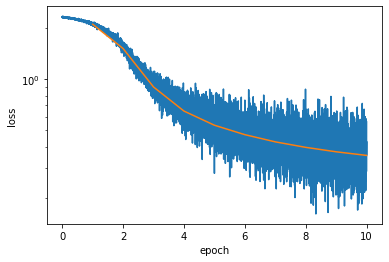

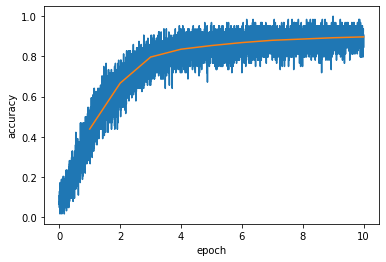

In [45]:
# Plotting the results
plt.figure()
plt.semilogy(np.linspace(0,10,len(losses_train)),losses_train)
plt.semilogy(np.linspace(1,10,len(losses_test)),losses_test)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


plt.figure()
plt.plot(np.linspace(0,10,len(acc_train)),acc_train)
plt.plot(np.linspace(1,10,len(acc_test)),acc_test)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

##  <span style="color:rgb(234,81,96)"> 3.2 Convolutional networks</span>

We will now use convolutional layers instead of fully connected layers.

In [46]:
class ConvNet(nn.Module):
    """ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x#F.log_softmax(x, dim=1)

In [47]:
model = ConvNet()
opt = "SGD"
# Use the function below if GPUs are available
#losses_train, losses_test,acc_train, acc_test = train(model,bs=64,n_epochs=10,optimizer=opt)
# Use the function below if no GPU is available
losses_train, losses_test,acc_train, acc_test = train(model,bs=64,n_epochs=10,optimizer=opt,gpu_mode=False)

Epoch [1/10], [3200/60000], batch loss = 2.291274070739746, epoch time = 2.475829601287842
Epoch [1/10], [6400/60000], batch loss = 2.2720377445220947, epoch time = 4.81854510307312
Epoch [1/10], [9600/60000], batch loss = 2.2431106567382812, epoch time = 7.197681188583374
Epoch [1/10], [12800/60000], batch loss = 2.253396987915039, epoch time = 9.548489332199097
Epoch [1/10], [16000/60000], batch loss = 2.2198281288146973, epoch time = 11.950687885284424
Epoch [1/10], [19200/60000], batch loss = 2.163238286972046, epoch time = 14.352348566055298
Epoch [1/10], [22400/60000], batch loss = 2.1382241249084473, epoch time = 16.69381833076477
Epoch [1/10], [25600/60000], batch loss = 2.132157802581787, epoch time = 19.027663469314575
Epoch [1/10], [28800/60000], batch loss = 2.064349412918091, epoch time = 21.398418188095093
Epoch [1/10], [32000/60000], batch loss = 1.9909018278121948, epoch time = 23.821786642074585
Epoch [1/10], [35200/60000], batch loss = 2.008704423904419, epoch time = 

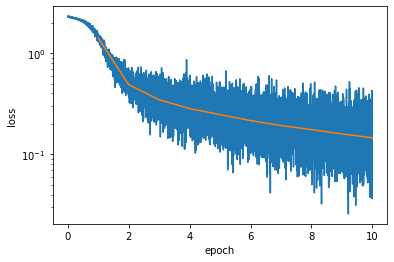

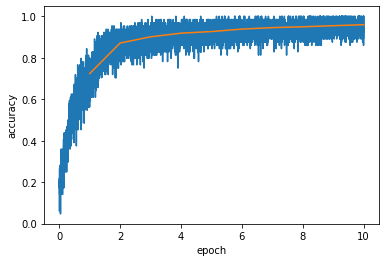

In [48]:
# Plotting the results
plt.figure()
plt.semilogy(np.linspace(0,10,len(losses_train)),losses_train)
plt.semilogy(np.linspace(1,10,len(losses_test)),losses_test)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


plt.figure()
plt.plot(np.linspace(0,10,len(acc_train)),acc_train)
plt.plot(np.linspace(1,10,len(acc_test)),acc_test)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

##  <span style="color:rgb(234,81,96)"> 3.3 Comparison of ```gpu_mode```</span>


**This section requires to have a GPU available - Cannot be run on CPUs.**


In this section your goal is to compare on one epoch the time when the models are run on gpus or cpus on one epoch of training.

In [49]:
model = ConvNet()
opt = "SGD"
losses_train, losses_test,acc_train, acc_test = train(model,bs=64,n_epochs=1,optimizer=opt,gpu_mode =True)
# Results below are given for a run on Google Colabs
#Epoch [1/1], [6400/60000], batch loss = 0.25592249631881714, epoch time = 1.8242907524108887
#Epoch [1/1], [12800/60000], batch loss = 0.16618403792381287, epoch time = 3.5998780727386475
#Epoch [1/1], [19200/60000], batch loss = 0.03176499903202057, epoch time = 5.348331689834595
#Epoch [1/1], [25600/60000], batch loss = 0.21775972843170166, epoch time = 7.101007699966431
#Epoch [1/1], [32000/60000], batch loss = 0.03961403667926788, epoch time = 8.855834007263184
#Epoch [1/1], [38400/60000], batch loss = 0.02127920836210251, epoch time = 10.629091024398804
#Epoch [1/1], [44800/60000], batch loss = 0.052795153111219406, epoch time = 12.460267543792725
#Epoch [1/1], [51200/60000], batch loss = 0.05879978463053703, epoch time = 14.238498449325562
#Epoch [1/1], [57600/60000], batch loss = 0.13118669390678406, epoch time = 16.037851095199585
#Epoch [1/1], test accuracy = 0.9812, testloss = 0.05701951904296875, total epoch time = 19.066580533981323


Epoch [1/1], [3200/60000], batch loss = 2.2969837188720703, epoch time = 0.6840066909790039
Epoch [1/1], [6400/60000], batch loss = 2.2870593070983887, epoch time = 1.2793736457824707
Epoch [1/1], [9600/60000], batch loss = 2.261462926864624, epoch time = 1.8419694900512695
Epoch [1/1], [12800/60000], batch loss = 2.245049476623535, epoch time = 2.404733180999756
Epoch [1/1], [16000/60000], batch loss = 2.2185137271881104, epoch time = 2.9558651447296143
Epoch [1/1], [19200/60000], batch loss = 2.2175135612487793, epoch time = 3.5247721672058105
Epoch [1/1], [22400/60000], batch loss = 2.2002086639404297, epoch time = 4.084828853607178
Epoch [1/1], [25600/60000], batch loss = 2.147818088531494, epoch time = 4.648583650588989
Epoch [1/1], [28800/60000], batch loss = 2.136775255203247, epoch time = 5.20771050453186
Epoch [1/1], [32000/60000], batch loss = 2.1195061206817627, epoch time = 5.791024208068848
Epoch [1/1], [35200/60000], batch loss = 2.067978620529175, epoch time = 6.36439633

In [50]:
model = ConvNet()
opt = "SGD"
losses_train, losses_test,acc_train, acc_test = train(model,bs=64,n_epochs=1,optimizer=opt,gpu_mode =False)

Epoch [1/1], [3200/60000], batch loss = 2.286106586456299, epoch time = 2.208163261413574
Epoch [1/1], [6400/60000], batch loss = 2.2451999187469482, epoch time = 4.338131666183472
Epoch [1/1], [9600/60000], batch loss = 2.2522823810577393, epoch time = 6.434709787368774
Epoch [1/1], [12800/60000], batch loss = 2.201765537261963, epoch time = 8.571654558181763
Epoch [1/1], [16000/60000], batch loss = 2.2090747356414795, epoch time = 10.767637252807617
Epoch [1/1], [19200/60000], batch loss = 2.16682767868042, epoch time = 12.950025796890259
Epoch [1/1], [22400/60000], batch loss = 2.1500165462493896, epoch time = 15.047606468200684
Epoch [1/1], [25600/60000], batch loss = 2.149719476699829, epoch time = 17.135181665420532
Epoch [1/1], [28800/60000], batch loss = 2.1202404499053955, epoch time = 19.24329900741577
Epoch [1/1], [32000/60000], batch loss = 2.034745454788208, epoch time = 21.348342657089233
Epoch [1/1], [35200/60000], batch loss = 1.9964056015014648, epoch time = 23.4446218

##  <span style="color:rgb(234,81,96)"> 3.4 Comparison of optimizers</span>

FInally, we compare 3 of the main optimizers in PyTorch, namely ADAM, RMSprop and SGD, for training convolutional neural networks.

In [51]:
# Compare three optimizers
optimizers = ["SGD","Adam","RMSprop"]
losses_train, losses_test,acc_train, acc_test = {},{},{},{}

for opt in optimizers:
    model = ConvNet()
    #losses_train[opt], losses_test[opt],acc_train[opt], acc_test[opt] = train(model,bs=64,n_epochs=10,optimizer=opt,gpu_mode =True)
    # Use this command if GPUs are not available
    losses_train[opt], losses_test[opt],acc_train[opt], acc_test[opt] = train(model,bs=64,n_epochs=10,optimizer=opt,gpu_mode=False)


Epoch [1/10], [3200/60000], batch loss = 2.3024282455444336, epoch time = 2.194108486175537
Epoch [1/10], [6400/60000], batch loss = 2.2559874057769775, epoch time = 4.379814147949219
Epoch [1/10], [9600/60000], batch loss = 2.228447198867798, epoch time = 6.551106929779053
Epoch [1/10], [12800/60000], batch loss = 2.198899507522583, epoch time = 8.807650804519653
Epoch [1/10], [16000/60000], batch loss = 2.171481132507324, epoch time = 10.991693496704102
Epoch [1/10], [19200/60000], batch loss = 2.188828945159912, epoch time = 13.249772787094116
Epoch [1/10], [22400/60000], batch loss = 2.131582021713257, epoch time = 15.40365743637085
Epoch [1/10], [25600/60000], batch loss = 2.075411081314087, epoch time = 17.56035280227661
Epoch [1/10], [28800/60000], batch loss = 2.036778211593628, epoch time = 19.704362392425537
Epoch [1/10], [32000/60000], batch loss = 1.9950308799743652, epoch time = 21.938392639160156
Epoch [1/10], [35200/60000], batch loss = 1.9351590871810913, epoch time = 2

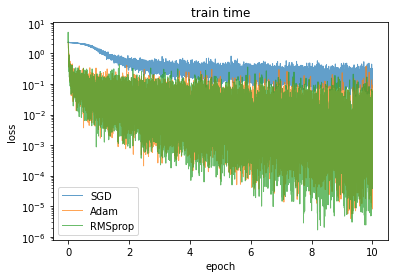

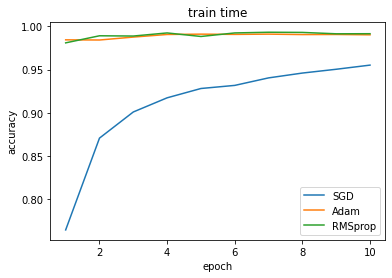

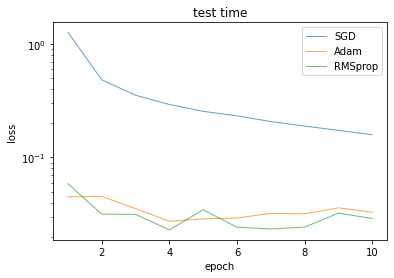

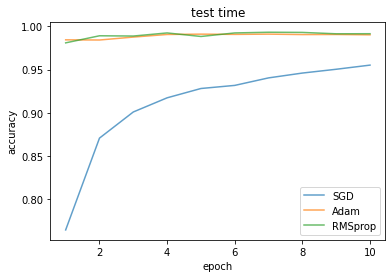

In [52]:
# Plotting the results
plt.figure()
for opt in optimizers:
    plt.plot(np.linspace(0,10,len(losses_train[opt])),losses_train[opt],label=opt,linewidth=1,alpha=0.7)
plt.yscale("log")
plt.legend()
plt.title("train time")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure()
for opt in optimizers:
    plt.plot(np.linspace(1,10,len(acc_test[opt])),acc_test[opt],label=opt)
plt.legend()
plt.title("train time")

plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()



plt.figure()
for opt in optimizers:
    plt.plot(np.linspace(1,10,len(losses_test[opt])),losses_test[opt],label=opt,linewidth=1,alpha=0.7)
plt.yscale("log")
plt.legend()
plt.title("test time")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure()
for opt in optimizers:
    plt.plot(np.linspace(1,10,len(acc_test[opt])),acc_test[opt],label=opt,alpha=0.7)
plt.legend()
plt.title("test time")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [ ]:
# Based on a notebook initially proposed with Laurent Meunier in 2019-2020.
# Version 2.0 - C. W. Royer, November 2023